In [1]:
import jax
import numpyro
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import blackjax

rng_key = jax.random.PRNGKey(0) 
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam

/Users/madhav/anaconda3/envs/experiment-new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def inference(model):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
    mcmc.run(rng_key, extra_fields=('potential_energy',))
    mcmc.print_summary(exclude_deterministic=False)
    return mcmc.get_samples()

In [3]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [4]:
def scatterplt(samples, cp = True):
    if(cp):
        plt.scatter(samples['theta'], samples['mu'])
        plt.xlabel('theta')
    else:
        plt.scatter(samples['theta_decentered'], samples['mu'])
        plt.xlabel('theta_decentered')
    plt.ylabel('mu')
    plt.show()

In [5]:
init_samples = jax.random.normal(rng_key, shape=(10000,)) + 3

In [6]:
def model():
    mu = numpyro.sample('mu', dist.Normal(5, 1))
    tau = numpyro.sample('tau', dist.Normal(0,0.1))
    theta = numpyro.sample('theta', dist.Normal(mu, jnp.exp(tau)))
    numpyro.sample('obs', dist.Normal(theta, 1), obs=init_samples)

In [7]:
ncp_model = reparam(model, config={'theta': LocScaleReparam(0)})
samples_ncp = inference(ncp_model)

sample: 100%|██████████| 1500/1500 [00:07<00:00, 198.43it/s, 511 steps of size 1.18e-02. acc. prob=0.94]



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                mu      4.00      0.72      3.99      2.90      5.22    202.45      1.00
               tau      0.01      0.11      0.01     -0.19      0.17    296.22      1.01
             theta      3.01      0.01      3.01      2.99      3.03   1115.82      1.00
  theta_decentered     -0.96      0.71     -0.97     -2.19      0.06    187.00      1.01

Number of divergences: 0


In [8]:
from numpyro.infer.util import initialize_model

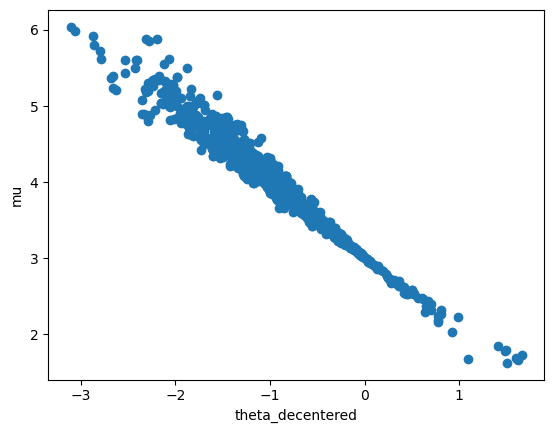

In [9]:
scatterplt(samples_ncp, cp=False)

sample: 100%|██████████| 1500/1500 [00:01<00:00, 801.86it/s, 3 steps of size 7.43e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.05      0.70      4.03      2.84      5.13    830.43      1.00
       tau      0.01      0.10      0.01     -0.16      0.18    754.55      1.00
     theta      3.01      0.01      3.01      3.00      3.03    894.51      1.00

Number of divergences: 0


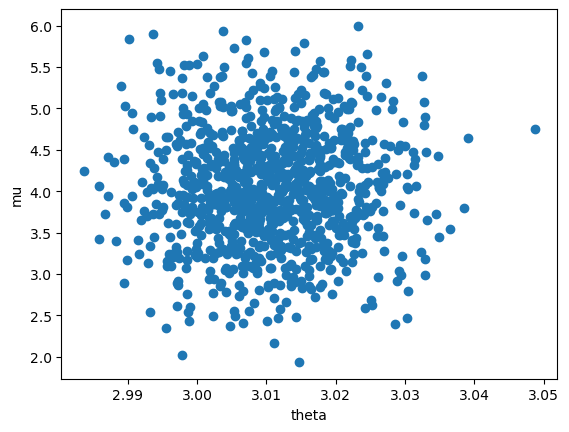

In [10]:
samples = inference(model)
scatterplt(samples)

## Windowed Non Linear Reparam

In [ ]:
num_warmup = 4000

adapt = blackjax.window_adaptation(blackjax.nuts, model)
key = jax.random.PRNGKey(0)
(last_state, parameters), intermediate_states,logdensity_fn  = adapt.run(key, num_warmup)
kernel = blackjax.nuts(logdensity_fn , **parameters).step

In [ ]:
num_sample = 1000

states, infos = inference_loop(key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

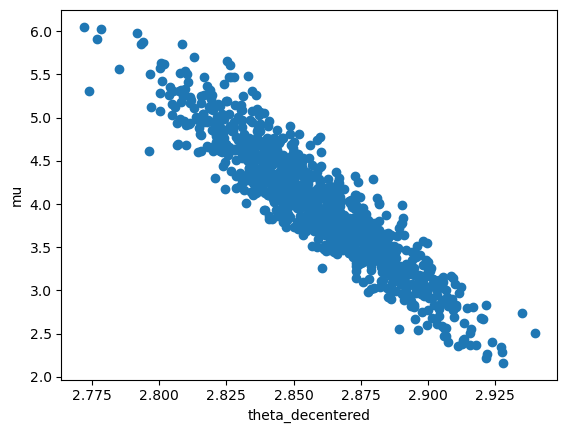

In [ ]:
scatterplt(states[0], cp=False)

## Maria's Method

In [ ]:
def model():
    mu = numpyro.sample('mu', dist.Normal(5, 1))
    tau = numpyro.sample('tau', dist.Normal(0,0.1))
    with numpyro.handlers.reparam(config={'theta': LocScaleReparam(None)}):
        theta = numpyro.sample('theta', dist.Normal(mu, jnp.exp(tau)))
    numpyro.sample('obs', dist.Normal(theta, 1), obs=init_samples)

In [ ]:
guide = AutoDiagonalNormal(model)
svi = SVI(model, guide, numpyro.optim.Adam(.1), Trace_ELBO(100))
params = svi.run(rng_key, 10000).params
params

100%|██████████| 10000/10000 [00:22<00:00, 440.95it/s, init loss: 211414.6562, avg. loss [9501-10000]: 14306.5898]


{'auto_loc': Array([4.0045977e+00, 3.0826190e-03, 2.9874969e+00], dtype=float32),
 'auto_scale': Array([0.564838  , 0.09854069, 0.00987033], dtype=float32),
 'theta_centered': Array(0.99414045, dtype=float32)}

In [ ]:
reparam_model = reparam(model, config={"theta": LocScaleReparam(centered=jnp.array(params['theta_centered']))})
samples_locscale = inference(model)

sample: 100%|██████████| 1500/1500 [00:04<00:00, 330.43it/s, 127 steps of size 2.28e-02. acc. prob=0.93]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                mu      4.03      0.70      4.05      2.74      5.11    194.09      1.00
               tau      0.01      0.11      0.01     -0.16      0.18    367.73      1.01
             theta      3.01      0.01      3.01      3.00      3.03    979.37      1.00
  theta_decentered      1.01      0.34      0.98      0.43      1.56    182.53      1.00

Number of divergences: 0


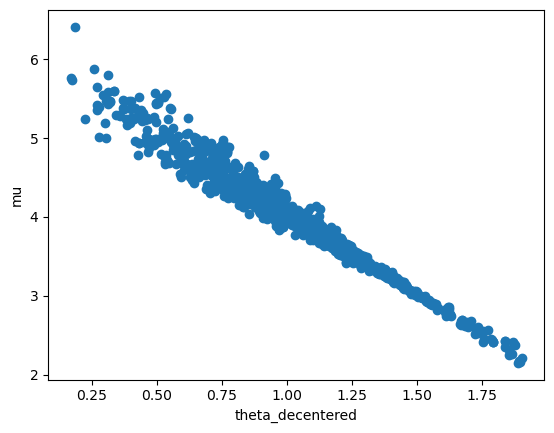

In [ ]:
scatterplt(samples_locscale, cp=False)